<img src="figs/NTU_logo.png" align="left" width="50" height="50" /> <br>
<h1 style="text-align:center"> XỬ LÝ DỮ LIỆU LỚN </h1>

<h1 style="text-align:center"> Lab 3: Phân tích dữ liệu thời tiết </h1>

- [Giới thiệu](#intro) <br>

- [Chương trình MapReduce ](#mapreduceprogram) <br>

- [Chạy ứng dụng trên Hadoop](#run_program) <br>
- [Bài tập](#excercises)


## Giới thiệu <a name="intro"/>

Bài thực hành này xử lý dữ liệu thu thập bởi [Trung tâm dữ liệu thời tiết Hoa Kỳ](https://www.ncdc.noaa.gov/) (NCDC). Dữ liệu được thu nhận từ các trạm quan trắc được đặt ở nhiều nơi, cung cấp các số đo về thời gian, tọa độ, nhiệt độ, áp suất không khí, hướng gió. <br>
Yêu cầu: Từ tập dữ liệu thu thập được, hãy tìm nhiệt độ cao nhất của mỗi năm.

<p align="center">
<img src="figs/ncdc_data_sample.png" width="70%"/>
<center>
    <caption>Minh họa một mẫu dữ liệu khí tượng từ NCDC. Trong thực tế mỗi bản ghi nằm trên một dòng, các trường dữ liệu liên tiếp nhau (không có ký tự phân cách). 
    </caption>
    <em>
        Nguồn: Tom White, Hadoop: The definitive Guide, 4th Ed.
    </em>
</center>
</p>

## Chương trình MapReduce  <a name = "mapreduceprogram"/>

### Map

In [1]:
#!/usr/bin/python3
'''mapper.py'''

import re
import sys

for line in sys.stdin:
  val = line.strip()
  (year, temp, q) = (val[15:19], val[87:92], val[92:93])
  # Nhiệt đô == "+9999" -> không có dữ liệu
  # q (quality code) == "01459" -> dữ liệu không bị lỗi
  if (temp != "+9999" and re.match("[01459]", q)):
    print("%s\t%s" % (year, temp))

### Reduce

In [2]:
#!/usr/bin/python3
'''reducer.py'''

import sys

(last_key, max_val) = (None, -sys.maxsize)
for line in sys.stdin:
  (key, val) = line.strip().split("\t")
  if last_key and last_key != key:
    print("%s\t%s" % (last_key, max_val))
    (last_key, max_val) = (key, int(val))
  else:
    (last_key, max_val) = (key, max(max_val, int(val)))

if last_key:
  print("%s\t%s" % (last_key, max_val))

## Chạy ứng dụng Hadoop MapReduce <a name="run_program"/>

### Khởi động Hadoop
Thực hiện lệnh sau:
```shell
start-all.sh
```

### Đưa dữ liệu lên HDFS 
Trước khi chạy chương trình MapReduce, cần đưa dữ liệu xử lý lên HDFS.

#### Tạo thư mục chứa dữ liệu trên HDFS
```shell
hdfs dfs -mkdir -p data/lab3
```
Hệ thống tạo thư mục `/user/hdoop/data/lab3` trên HDFS.
#### Đưa dữ liệu từ máy cục bộ lên HDFS
Giả sử thư mục chứa dữ liệu đầu vào là `/home/hung/Downloads/ncdc` chứa các files dữ liệu thời tiết của NCDC đã được tiền xử lý gộp theo từng năm.
Thực hiện lệnh sau để copy dữ liệu lên HDFS:
```shell
hdfs dfs -copyFromLocal /home/hung/Downloads/ncdc /user/hdoop/data/lab3
```

#### Chạy chương trình MapReduce
Giả sử 2 file `mapper.py` và `reducer.py` lưu ở thư mục `/home/hdoop/labs/lab3`.

- Chuyển dấu nhắc đến thư mục `lab3`:
```shel
cd /home/hdoop/labs/lab3
```
- Gọi chương trình MapReduce thông qua Hadoop Streaming:
```shell
hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-3.2.2.jar \
 -file mapper.py -mapper mapper.py \
 -file reducer.py -reducer reducer.py \
 -input /user/hdoop/data/lab3/ncdc \
 -output /user/hdoop/data/lab3/ncdc-output 
```

- Kiểm tra kết quả xử lý:
```shell
hdfs dfs -ls /user/hdoop/data/lab3/ncdc-output 
```

Copy file kết quả từ HDFS xuống máy ổ đĩa cục bộ:
```shell
hdfs dfs -copyToLocal /user/hdoop/data/lab3/ncdc-output/part-00000 .
```

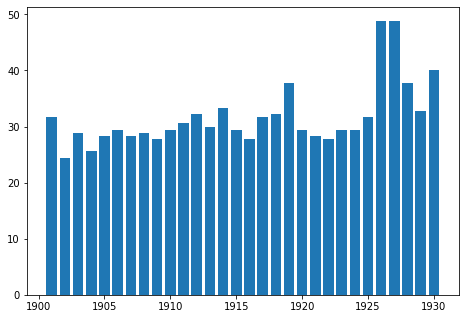

In [4]:
import pandas as pd 
import matplotlib.pyplot as plt

max_temps = pd.read_csv('part-00000', delimiter='\t', header=None, names=['year', 'temp'])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
years = max_temps['year']
temps = max_temps['temp']/10
ax.bar(years,temps)

plt.show()

## Bài tập <a name="excercises"/>


Thực hiện các xử lý sau trên tập dữ liệu NCDC:
- Tìm thời gian, tọa độ của nơi có nhiệt độ cao nhất mỗi năm.
- Tìm địa điểm trên trái đất tương ứng với tọa độ nóng nhất mỗi năm.


